### Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [23]:
technical_features = [
    "close_0",
    "close_sp500_0",
    "close_365",
    "close_sp500_365",
    "close__minus_120",
    "close_sp500__minus_120",
    "close__minus_365",
    "close_sp500__minus_365",
    "close__minus_730",
    "close_sp500__minus_730",
    "stock_change_365",
    "stock_change_div_365",
    "sp500_change_365",
    "stock_change__minus_120",
    "sp500_change__minus_120",
    "stock_change__minus_365",
    "sp500_change__minus_365",
    "stock_change__minus_730",
    "sp500_change__minus_730",
    "std__minus_365",
    "std__minus_730",
    "std__minus_120",
]

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [149]:
import pandas as pd
from pathlib import Path
import re
import numpy as np
import lightgbm as lgb
from plotnine import (
    ggplot,
    geom_histogram,
    aes,
    geom_col,
    coord_flip,
    geom_bar,
    coord_cartesian,
    geom_hline,
    geom_boxplot,
    scale_x_discrete,
    geom_point,
    theme,
    element_text,
)
import matplotlib.pyplot as plt

In [25]:
n_trees = 40  # number of trees in lightgbm
minimum_number_of_tickers = 1500
n_train_quarters = 36  # Number of the quarters in the past to train
top_n = 10  # number of tickers to make the portfolio

In [26]:
path_data_set = (
    Path().resolve().parent.parent / "data/financials_against_return.feather"
)
data_set = pd.read_feather(path_data_set)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [27]:
df_quarter_lengths = (
    data_set.groupby(["execution_date"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
data_set = pd.merge(data_set, df_quarter_lengths, on=["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [28]:
data_set.shape

(170483, 145)

Create the target:

In [29]:
data_set["diff_ch_sp500"] = (
    data_set["stock_change_div_365"] - data_set["sp500_change_365"]
)

data_set.loc[data_set["diff_ch_sp500"] > 0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"] < 0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [ ]:
def get_weighted_performance_of_stocks(
        df:pd.DataFrame, 
        metric: str
        ):
    df["norm_prob"] = 1 / len(df)
    return np.sum(df["norm_prob"] * df[metric])


def get_top_tickers_per_prob(preds:list):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert "Not matching train/test"
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending=False)
    data_set = data_set.head(top_n)
    return data_set


# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(
        preds:list,
        train_data:pd.DataFrame
        ):
    top_dataset = get_top_tickers_per_prob(preds)
    return (
        "weighted-return",
        get_weighted_performance_of_stocks(top_dataset, "diff_ch_sp500"),
        True,
    )

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [ ]:
def split_train_test_by_period(
    data_set:pd.DataFrame,
    test_execution_date:str,
    include_nulls_in_test:bool=False
    ):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[
        data_set["execution_date"]
        <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit="day")
    ]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters != None:
        train_set = train_set[
            train_set["execution_date"].isin(execution_dates[-n_train_quarters:])
        ]

    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values("date", ascending=False).drop_duplicates(
        "Ticker", keep="first"
    )

    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [221]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
    ]

    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [ ]:
import warnings

warnings.filterwarnings("ignore")


def train_model(
        train_set:pd.DataFrame,
        test_set:pd.DataFrame, 
        n_estimators:int=300):

    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    objective = "binary"
    metric = "binary_logloss"
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "n_estimators": n_estimators,
        "objective": objective,
        "metric": metric,
    }

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [ ]:
def run_model_for_execution_date(
    execution_date:str,
    all_results::pd.DataFrame,
    all_predicted_tickers_list:list,
    all_models::pd.DataFrame,
    n_estimators:int,
    include_nulls_in_test:bool=False,
):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    # if both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(
            train_set, test_set, n_estimators=n_estimators
        )

        test_set["prob"] = model.predict(X_test)
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


execution_dates = np.sort(data_set["execution_date"].unique())

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [ ]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}


def train_model_across_periods(n_estimators:int):
    global all_results
    global all_predicted_tickers_list
    global all_models
    global all_predicted_tickers

    for execution_date in execution_dates:
        print(execution_date)
        all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = (
            run_model_for_execution_date(
                execution_date,
                all_results,
                all_predicted_tickers_list,
                all_models,
                n_estimators,
                False,
            )
        )
    all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [ ]:
train_model_across_periods(n_estimators=params["n_estimators"])

In [ ]:
def parse_results_into_df(set_:str):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [37]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [ ]:
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")

And this are the results:

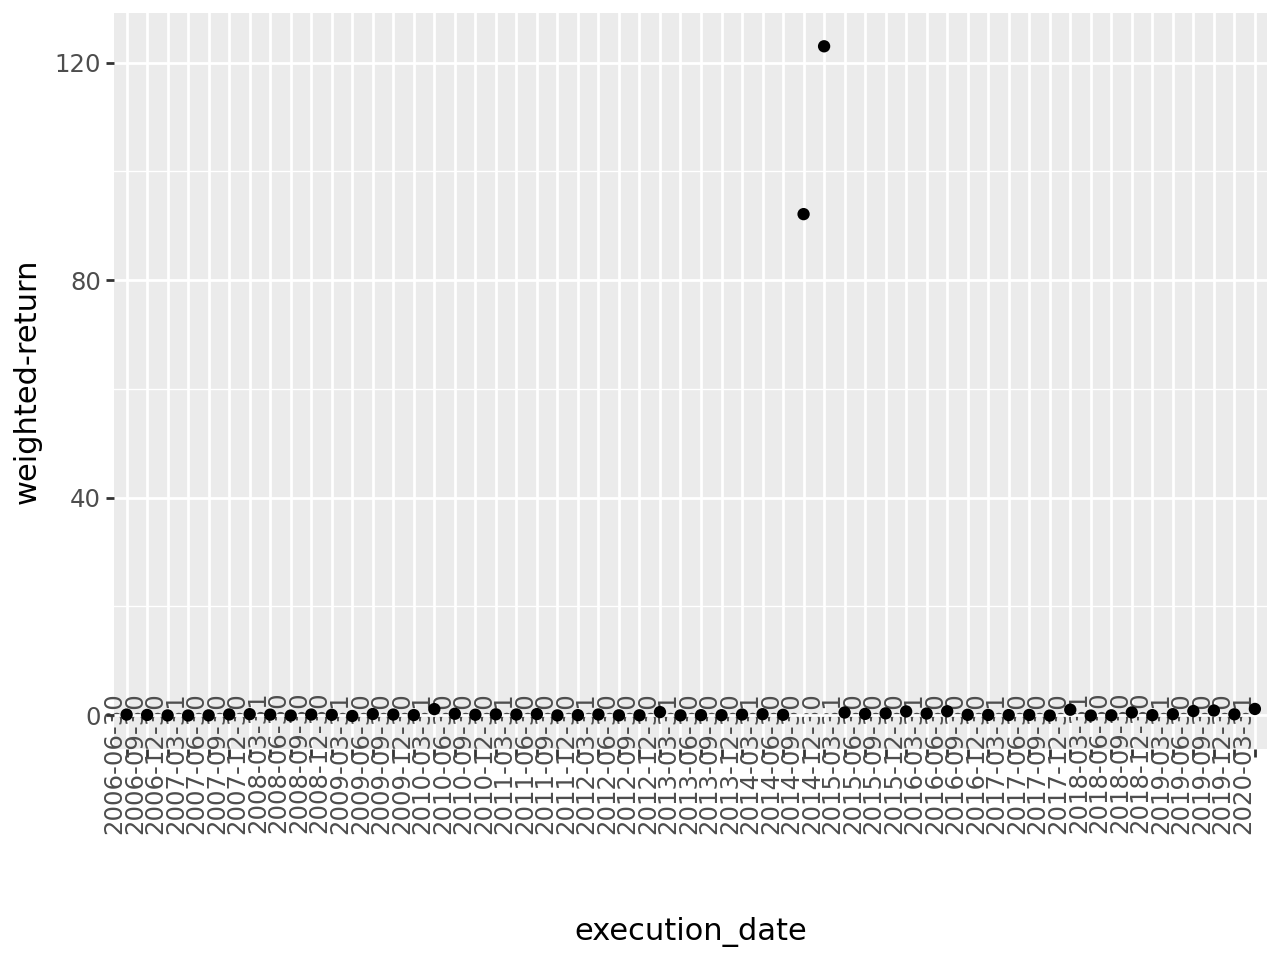

In [115]:
(
    ggplot(test_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

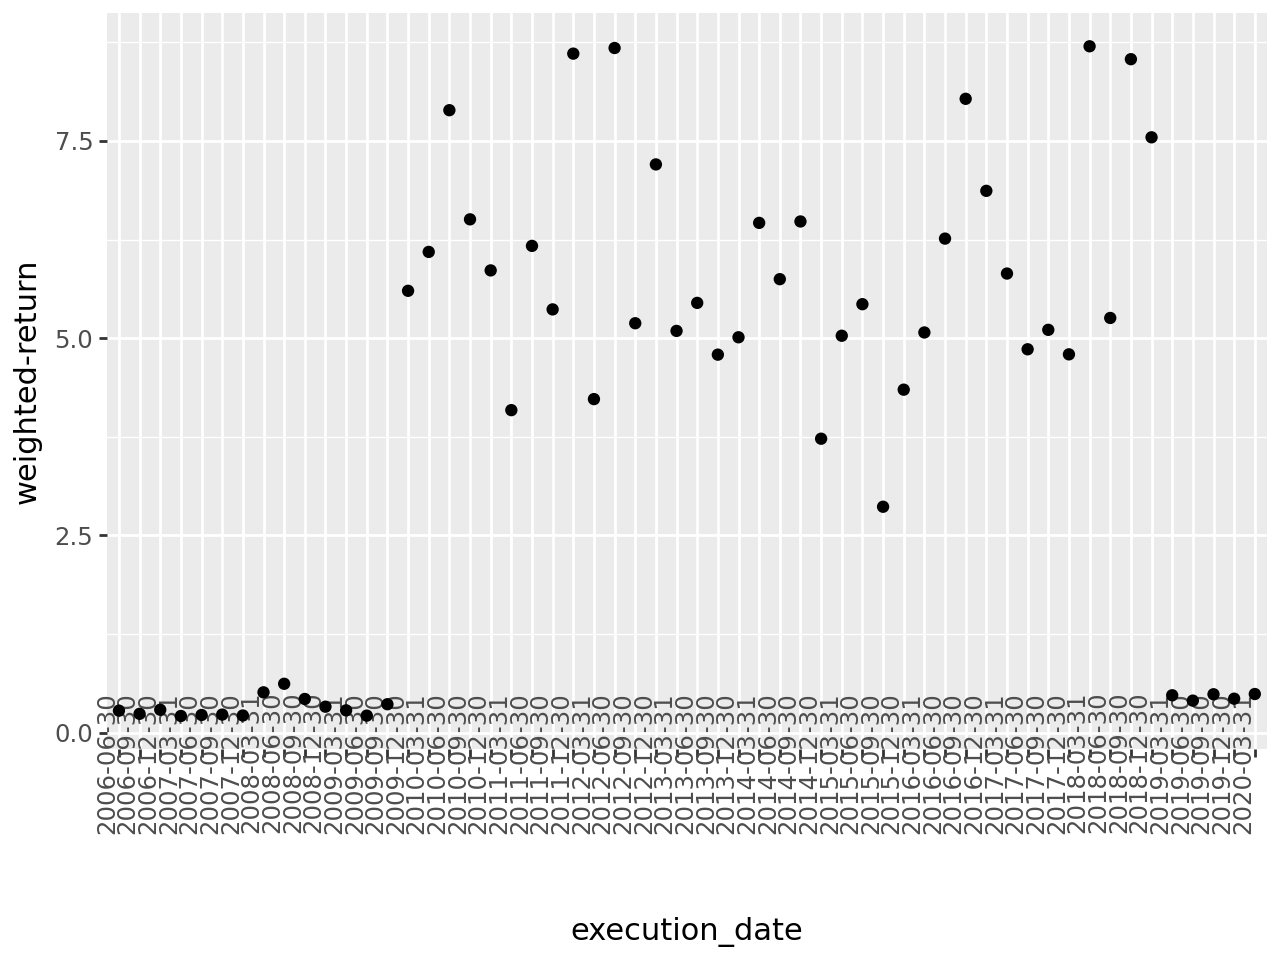

In [40]:
(
    ggplot(train_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

Hemos entrenado los primeros modelos para todos los períodos, pero hay muchos aspectos que podrían estar mal o mejorarse. Algunas ideas para empezar:
* Verificar si hay alguna fuga de datos o características sospechosas.
* Si el entrenamiento es muy lento, ver cómo modificarlo para ejecutar pruebas más rápidas.
* Verificar si el algoritmo está aprendiendo correctamente.
* Utilizamos una métrica de alto nivel para evaluar el algoritmo, por lo que quizás deba usar otras de bajo nivel.
* Verificar si hay sobreajuste.
* Verificar si hay mucho ruido entre los diferentes entrenamientos.
* Para simplificar, ¿por qué solo se conservan los primeros tickers de capitalización de mercado?
* Cambiar el número de trimestres para entrenar en el pasado.

Se puede evidenciar que las dos features de close_0 y close_sp50_0 tienen una valor alto en su importancia. Puede ser que las varaibles contienen un valor altamente predictivo o a que preseten data leakeage.
Estas varaibles  representan informacion relativa sobre la diferencia el precio del SP500 y el precio de la accion

# Proposed solution

1. Some feature values seem to have information about the stock from a future date after execution. This affects the model’s efficiency and introduces **data leakage**, making the model perform better than it should.  
`close_0, close_sp500_0, close_sp500_365, close_365`  

2. Financial indicators are published in reports **four times a year**, but these reports may not come out at the same time. This means the model could see data from some companies earlier than others, allowing it to guess information that **would not be available in production**. This creates **bias** and changes the model’s performance.

## BaseLine / Dumb model

I Develop a baseline to find out if the model it's better that a solution without Machine Learning. Create a simple average surplus (diferent bewteen the actual value and the average of the five years) over the SP500 and of the 500 Stocks with the market cap

In [75]:
def get_baseline(
    metrics_df: pd.DataFrame,
    all_predicted_tickers: pd.DataFrame,
    top_n_market_cap: int = 500,
):
    all_predicted_tickers = all_predicted_tickers.sort_values(
        ["execution_date", "Market_cap"], ascending=[False, False]
    )
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(
        ["execution_date"]
    ).cumcount()
    all_predicted_tickers_top_mc = all_predicted_tickers[
        all_predicted_tickers["rank"] <= top_n_market_cap
    ]
    baseline = (
        all_predicted_tickers_top_mc.groupby("execution_date")["diff_ch_sp500"]
        .mean()
        .reset_index()
    )
    baseline = baseline.rename(columns={"diff_ch_sp500": "diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)
    metrics_df = pd.merge(metrics_df, baseline, on="execution_date")
    return metrics_df

In [76]:
test_results_final_tree = get_baseline(test_results_final_tree, all_predicted_tickers)

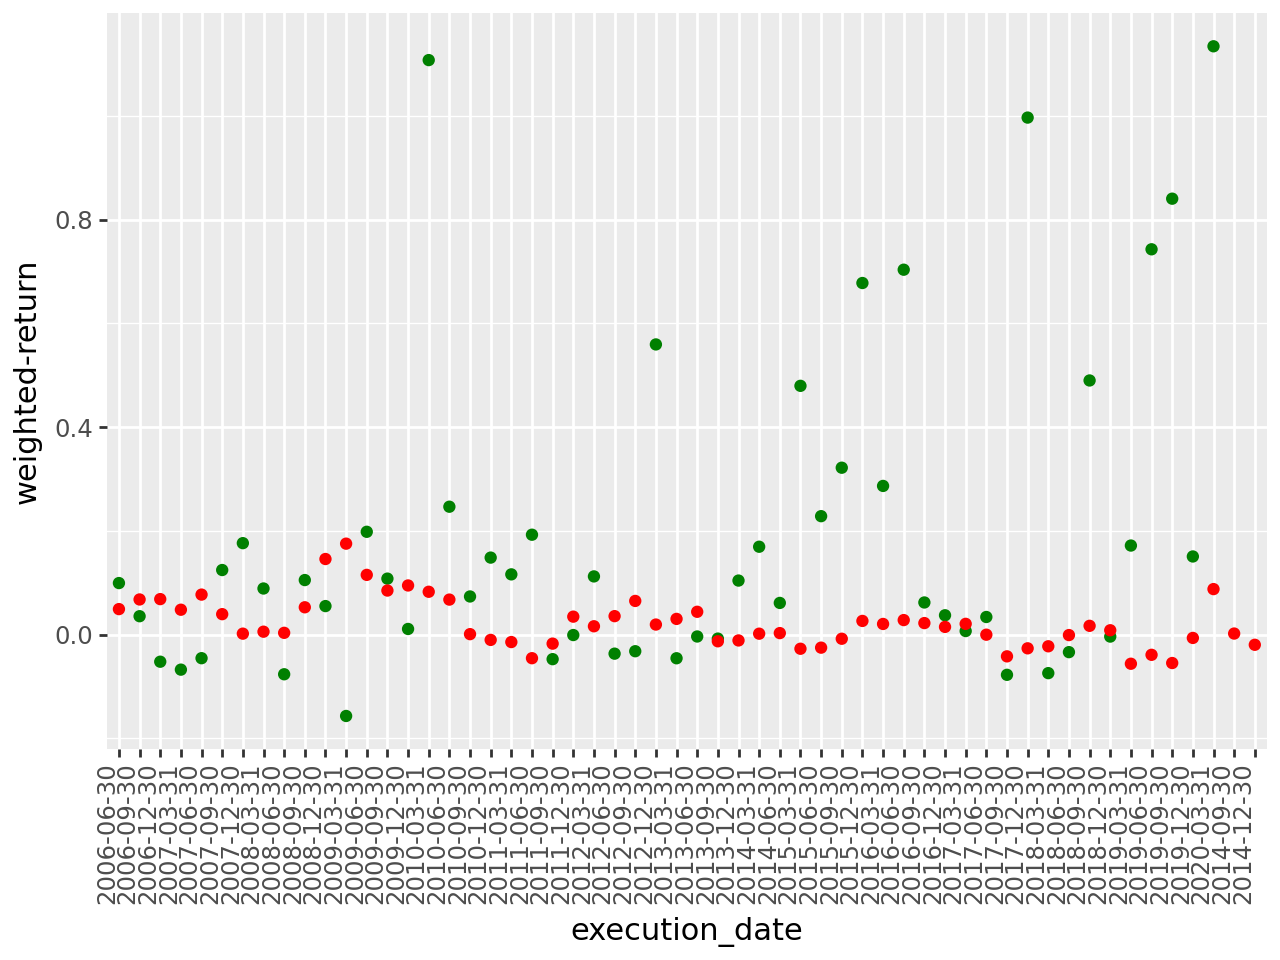

In [ ]:
plot = (
    ggplot()
    + geom_point(
        test_results_final_tree[test_results_final_tree["weighted-return"] < 2],
        aes(x="execution_date", y="weighted-return"),
        color="green",
    )
    + geom_point(
        test_results_final_tree[test_results_final_tree["diff_ch_sp500_baseline"] < 2],
        aes(x="execution_date", y="diff_ch_sp500_baseline"),
        color="red",
    )
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)
plot

How many perform are better in the baseline than the model

In [96]:
test_results_final_tree[
    test_results_final_tree["weighted-return"]
    < test_results_final_tree["diff_ch_sp500_baseline"]
].shape[0] / test_results_final_tree.shape[0]

0.3392857142857143

only in the 1/3 of the predicctions are better the baseline, show us that the model it better.

The median performance is: 

In [ ]:
print(
    f"model median: {test_results_final_tree['weighted-return'].median():.3f}  Baseline median: {test_results_final_tree['diff_ch_sp500_baseline'].median():.3f}"
)
print(
    f"model mean: {test_results_final_tree['weighted-return'].mean():.3f}  Baseline mean: {test_results_final_tree['diff_ch_sp500_baseline'].mean():.3f}"
)

model median: 0.105  Baseline median: 0.016
model mean: 4.029  Baseline mean: 0.022


The model is more risky taking more decision with high values making more mistakes, but when gets it right got a lot performance, while the the baseline es more conservator so makes less mistakes

## have the models overffiting?
The next step is check if the models are learning correctly generalizing at all and not learning from the data.

The next function showhow change the metric "binary_logloss" with the number of trees. This let us watch if the model it's getting better if  increases the number

In [ ]:
def return_learning_curve_line(set_name:str):
    learning_curves = []

    for date in all_results:
        metrics = all_results[date][set_name]
        n_trees = list(range(len(metrics["binary_logloss"])))
        logloss_values = metrics["binary_logloss"]

        df = pd.DataFrame(
            {
                "n_trees": n_trees,
                "binary_logloss": logloss_values,
                "execution_date": np.datetime_as_string(date),
            }
        )

        learning_curves.append(df)

    learning_curves_df = pd.concat(learning_curves, ignore_index=True)

    return learning_curves_df

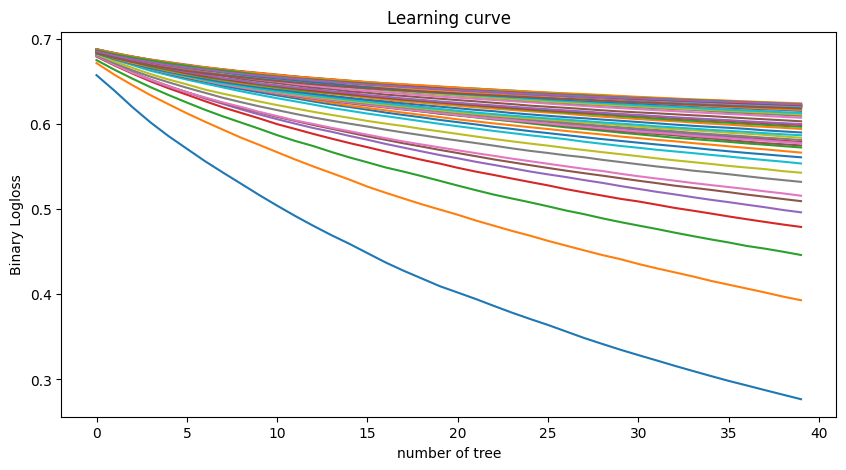

In [141]:
train_lc = return_learning_curve_line("training")


plt.figure(figsize=(10, 5))
for date in train_lc["execution_date"].unique():
    subset_train = train_lc[train_lc["execution_date"] == date]

    plt.plot(
        subset_train["n_trees"], subset_train["binary_logloss"], label=f"Train {date}"
    )

plt.xlabel("number of tree")
plt.ylabel("Binary Logloss")
plt.title("Learning curve")
# plt.legend()
plt.show()

In the graph while the number of trees increase, the binary logloss dicrease, show that the models are learning very well

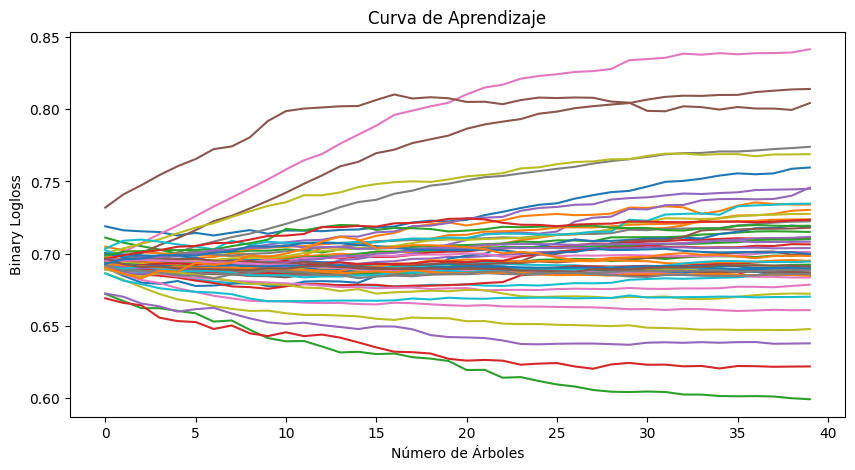

In [ ]:
valid_lc = return_learning_curve_line("valid_0")

plt.figure(figsize=(10, 5))
for date in train_lc["execution_date"].unique():

    subset_valid = valid_lc[valid_lc["execution_date"] == date]

    plt.plot(
        subset_valid["n_trees"], subset_valid["binary_logloss"], label=f"Valid {date}"
    )

plt.xlabel("Número de Árboles")
plt.ylabel("Binary Logloss")
plt.title("Curva de Aprendizaje")
# plt.legend()
plt.show()

In the valid graph, there are models, that doesn't learn, increasing the value of binary logloss, maybe for overffiting. Very few models actually are learning, and the majory mantein the constan error.

In [ ]:
def return_learning_curve(set_name:str):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(
                ["execution_date"]
            )
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(
                learning_curves, first_metric, on=["execution_date"]
            )
            learning_curves["norm_" + column] = (
                learning_curves[column] - learning_curves["first_" + column]
            ) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

In [129]:
test_lc = return_learning_curve("valid_0")
train_lc = return_learning_curve("training")

train_lc["n_trees_cat"] = pd.Categorical(
    train_lc["n_trees"], categories=sorted(train_lc["n_trees"].unique())
)
test_lc["n_trees_cat"] = pd.Categorical(
    test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
)

The same graph, but using boxplots. In this graphic the boxplot represent all the models of the periods and the comparate with the first period, and normaliced the values. Further let us see the outliers and the median
The metrics it's the same binary_log_loss.

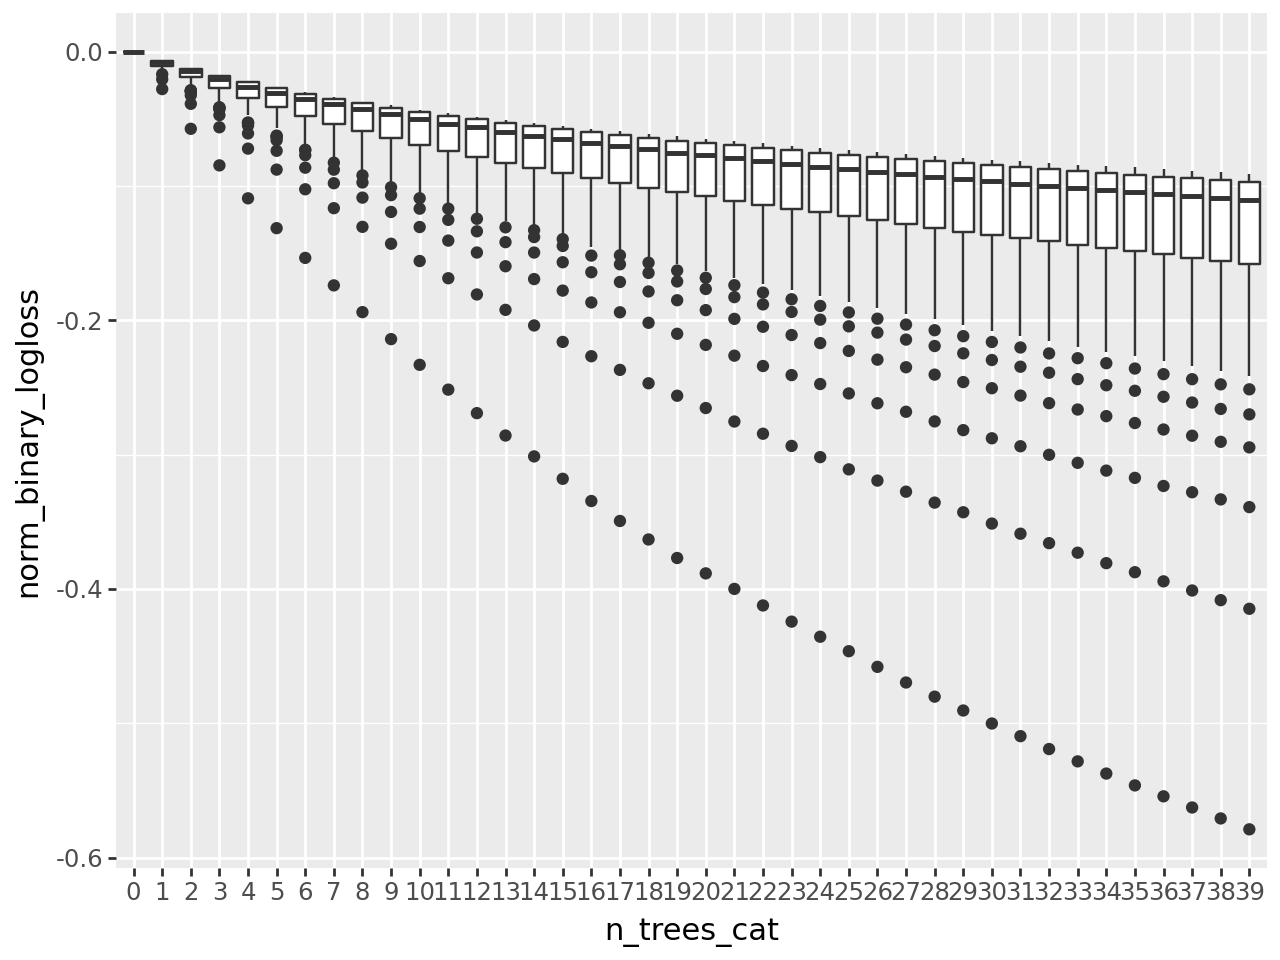

In [ ]:
ggplot(train_lc, aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot()

In the grapic, we can see that respectly the first tree, the metrics dicrease, showing that the model learning and get better.

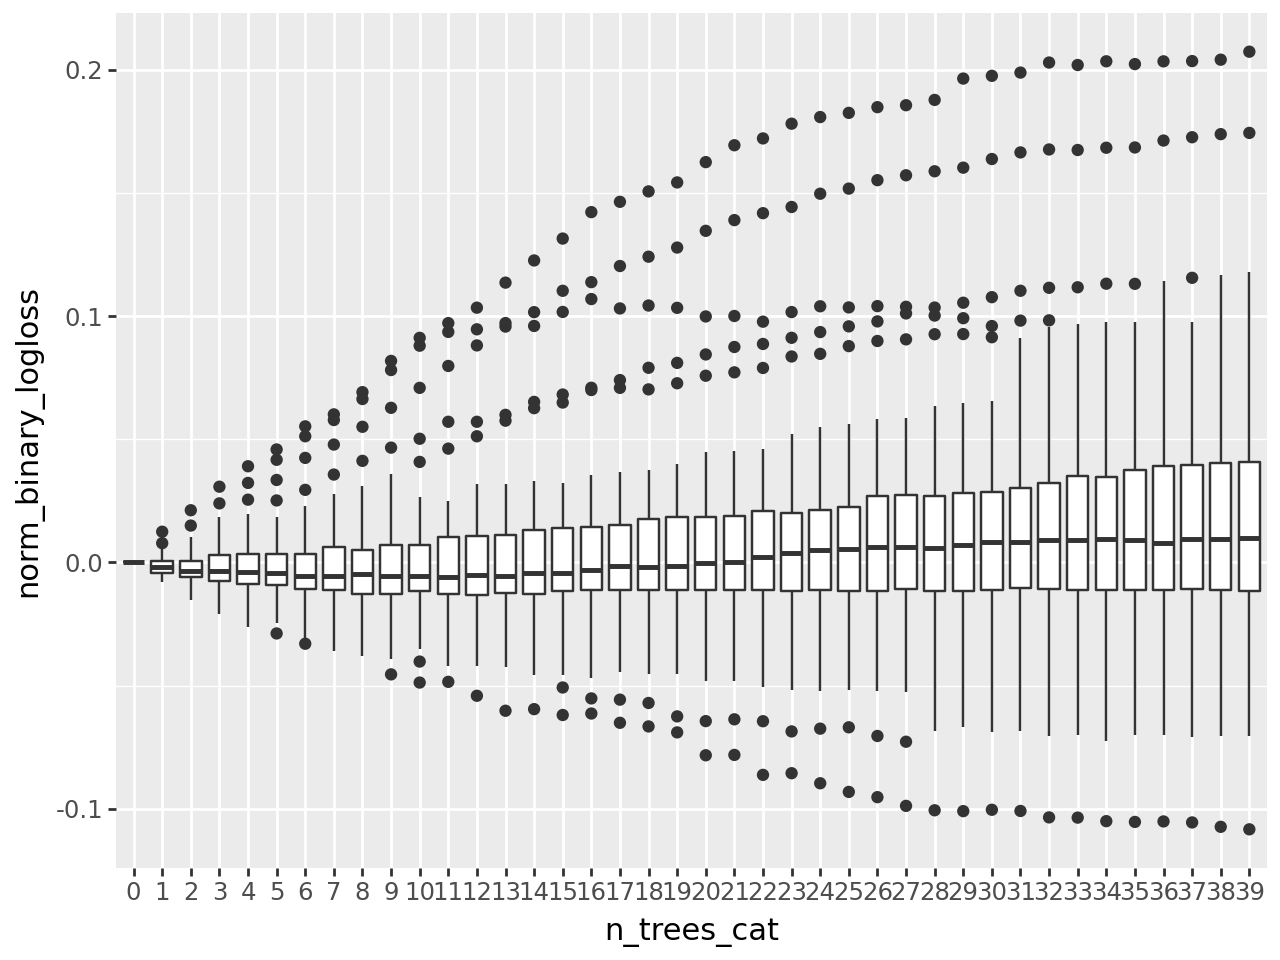

In [ ]:
ggplot(test_lc, aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot()

In valid, we see the outlier are modificate all the behavior in the graph of lines, but in the same way, the models are not generalize, the median are around the value of 0, that means that the model are not learning, and there are overffiting.

How ever, the median it was getting better before the 10 tree, and then come back to zero. After this point the models have to much overffiting.

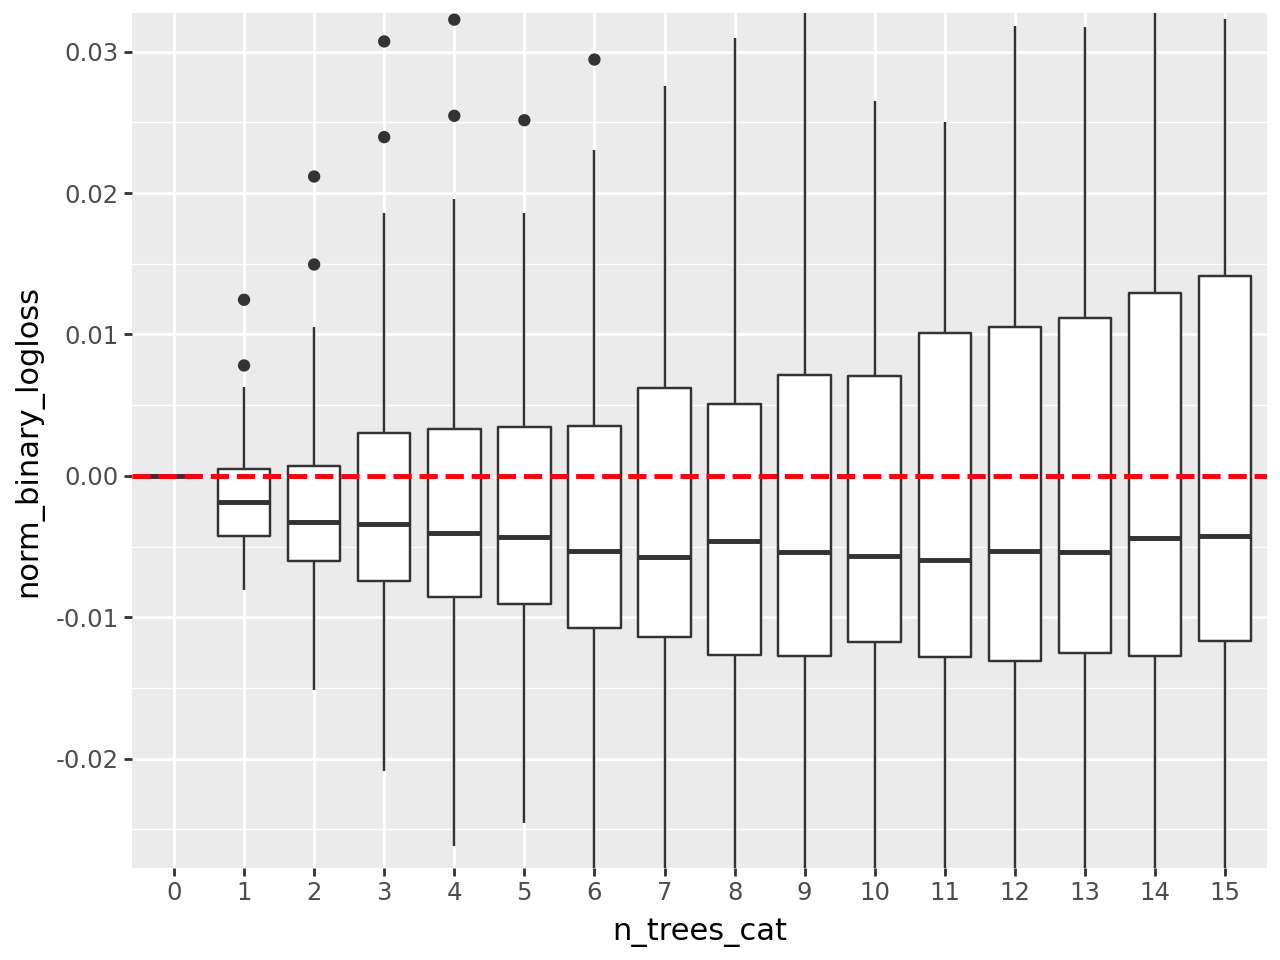

In [ ]:
(
    ggplot(
        test_lc[test_lc["n_trees"] < 16], aes(x="n_trees_cat", y="norm_binary_logloss")
    )
    + geom_boxplot(outlier_alpha=None)
    + coord_cartesian(ylim=[-0.025, 0.03])
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
)

Now we can see the median decreasing until the number 12 (ignoring the 8 maybe stochatist) and get up. To avoid the overffitihg, we have to try to simplify our model until it generalises, and change the model parameters. Once the model works right, we can add complexity bit by bit. 

Also it's importance to aviod the manual overfitting by only change parameter very specifically, so the change have to very small.

Changes:  
-Number of estimators: So put the number of thee in 12.  
-Leaning rate: control how much the model has learning from the data comparates with the previous iteraccion  
Start with small learning rate, to give more control over the variance of the model

In [222]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

train_model_across_periods(n_estimators=20)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

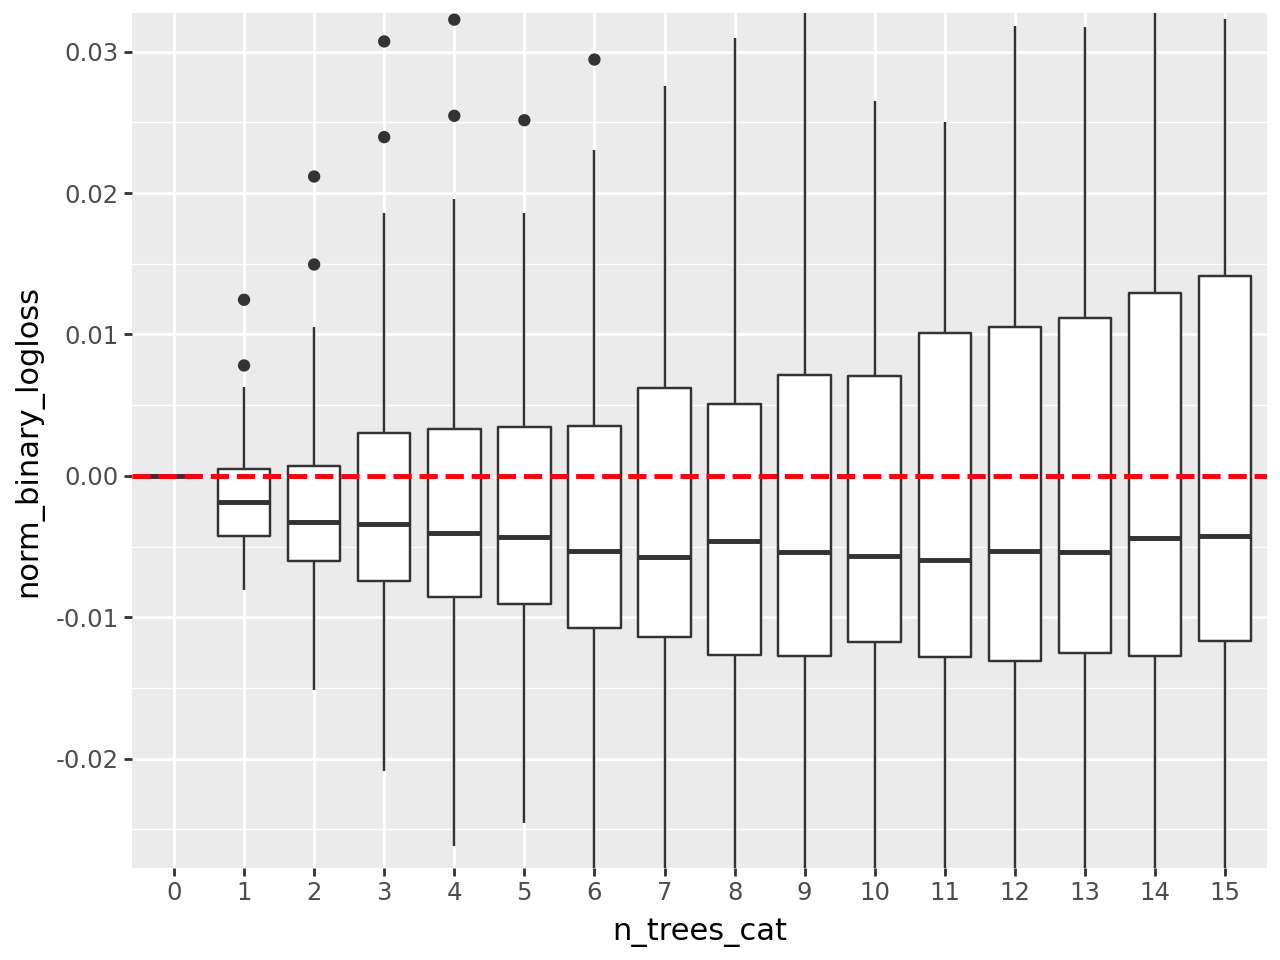

In [223]:
test_lc = return_learning_curve("valid_0")

test_lc["n_trees_cat"] = pd.Categorical(
    test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
)


(
    ggplot(
        test_lc[test_lc["n_trees"] < 16], aes(x="n_trees_cat", y="norm_binary_logloss")
    )
    + geom_boxplot(outlier_alpha=None)
    + coord_cartesian(ylim=[-0.025, 0.03])
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
)

The median decrease constanly in comparate with the before number of tree avoiding to close to zero. That's means we are learning something as we train more trees.

Feature importance

Now we see the importance in each model and get the mean to see if there are some feature that have high importance

In [ ]:
def draw_feature_importance(model, top:int=15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame(
        [{"feature": fn[i], "imp": fi[i]} for i in range(len(fi))]
    )
    feature_importance = feature_importance.sort_values("imp", ascending=False).head(
        top
    )
    feature_importance = feature_importance.sort_values("imp", ascending=True)
    plot = (
        ggplot(feature_importance, aes(x="feature", y="imp"))
        + geom_col(fill="lightblue")
        + coord_flip()
        + scale_x_discrete(limits=feature_importance["feature"])
    )
    return feature_importance

In [207]:
feature_importance_summary = {}

for model_name, model in all_models.items():
    feature_importance = draw_feature_importance(model)

    feature_importance_df = pd.DataFrame(
        {
            "Feature": feature_importance["feature"],
            "Importance": feature_importance["imp"],
        }
    )

    feature_importance_summary[model_name] = feature_importance_df.set_index("Feature")[
        "Importance"
    ]

feature_importance_summary_df = pd.DataFrame(feature_importance_summary)
feature_importance_summary_df["Mean_Importance"] = feature_importance_summary_df.mean(
    axis=1
)
feature_importance_summary_df = feature_importance_summary_df.sort_values(
    by="Mean_Importance", ascending=False
)

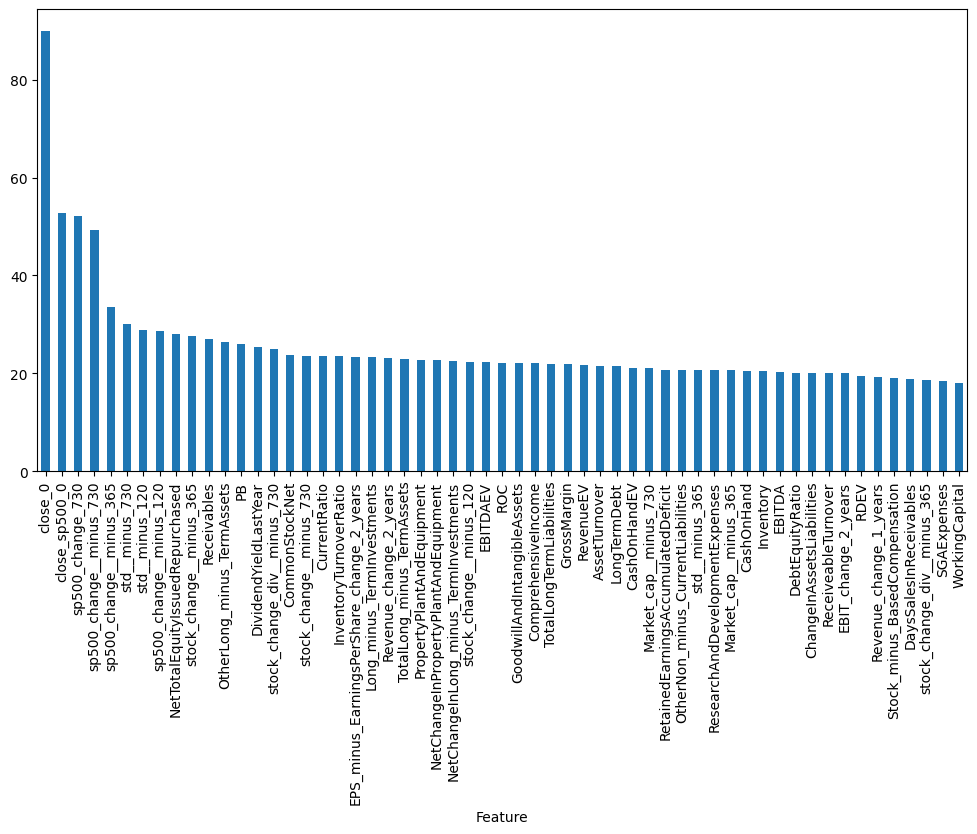

In [208]:
feature_importance_summary_df["Mean_Importance"].plot(kind="bar", figsize=(12, 6))
plt.show()

The feature 'close_0' have a high importance in the majory models, might be for a data leakeage. we can find out with the shap

In [ ]:
import shap


def get_shap_values_for_ticker_execution_date(execution_date:str, ticker=None):
    date = np.datetime64(execution_date)
    model_ = all_models[date]
    fn = model_.feature_name()

    X_test = all_predicted_tickers[(all_predicted_tickers["execution_date"] == date)]
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]

    X_test["Ticker"] = X_test["Ticker"].astype("category")
    X_test = X_test.sort_values("Ticker")

    if ticker is not None:
        explainer = shap.Explainer(model_)
        shap_values = explainer(X_test[fn])
        shap_values = shap_values[0]
    else:
        explainer = shap.Explainer(model_, X_test[fn])
        shap_values = explainer(X_test[fn])

    return shap_values

 90%|==================  | 2016/2235 [00:16<00:01]       

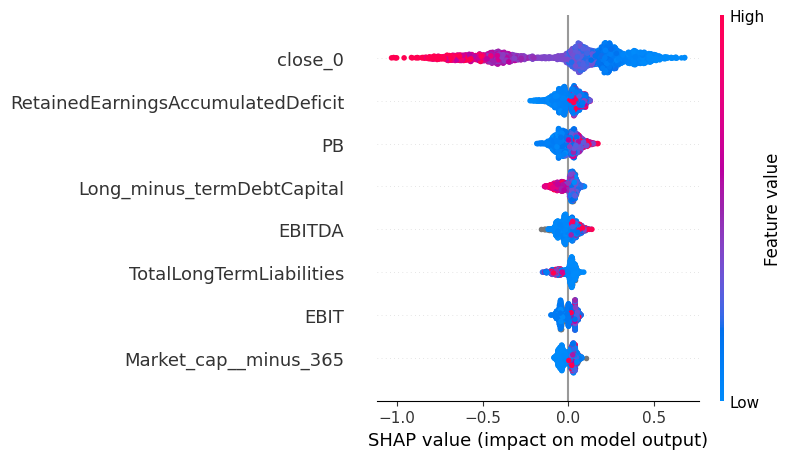

In [211]:
sv = get_shap_values_for_ticker_execution_date("2009-06-30T00:00:00.000000000")
shap.summary_plot(sv, max_display=8)

As the importance mean, SHAP, said the same, the feature 'close_0' it's high.
close_0 it´s the price of the stock at the time of the prediction.

From research on this characteristic and other analyses of this same problem, we arrive at a common problem.

The history of CYCC stock prices looks wrong because of something called reverse splits. These splits make the price look much higher than it really was. A reverse split happens when the stock price gets too low, and they adjust the number of shares and the price, but it’s just a way to make the price look better on paper.

The model is wrongly learning that if the price is high, it means a reverse split will happen later, and this causes it to make wrong predictions. This is called **data leakage**, which means the model is getting information it shouldn't have.

To fix this, we need to remove the features that are causing the problem and train the model again with better data.

In [ ]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp580_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
        "stock_change_div__minus_365",
    ]
    columns_to_remove += technical_features
    return columns_to_remove

We remove the feature that can be have data leakage for its price. And train again with this changes 

In [238]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_permutation_importances = pd.DataFrame()

train_model_across_periods(20)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

We chaeck how was going the train, with the learning curve. And was going like was expected.

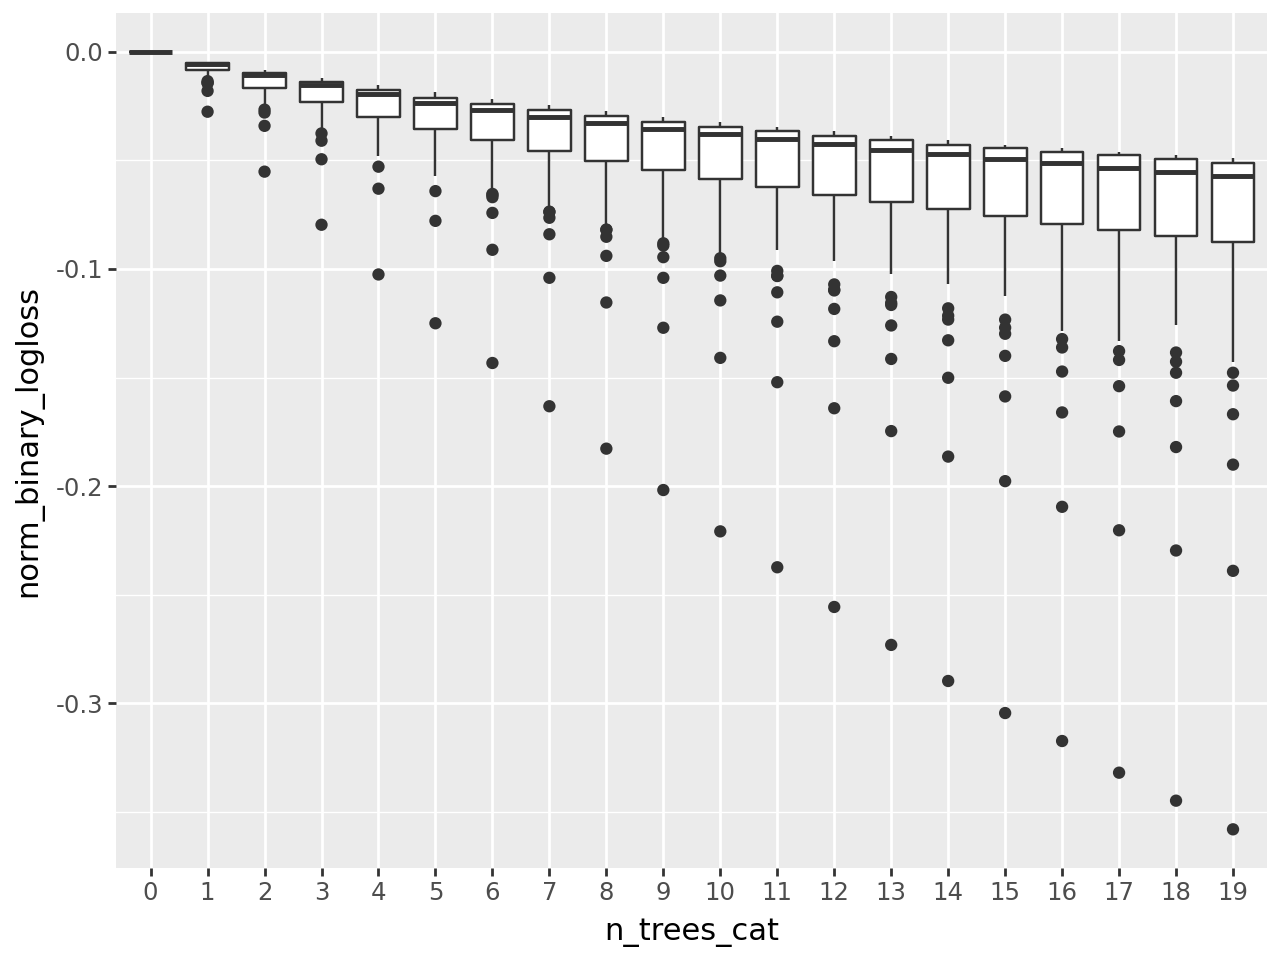

In [239]:
test_lc = return_learning_curve("valid_0")
train_lc = return_learning_curve("training")

train_lc["n_trees_cat"] = pd.Categorical(
    train_lc["n_trees"], categories=sorted(train_lc["n_trees"].unique())
)
test_lc["n_trees_cat"] = pd.Categorical(
    test_lc["n_trees"], categories=sorted(test_lc["n_trees"].unique())
)

ggplot(train_lc, aes(x="n_trees_cat", y="norm_binary_logloss")) + geom_boxplot()

In the tes,t the median decreases, but not as much as before, because data leakage no longer exists. However, we can be sure that it is not learning from the data and that it is not using information that will not be available in production.

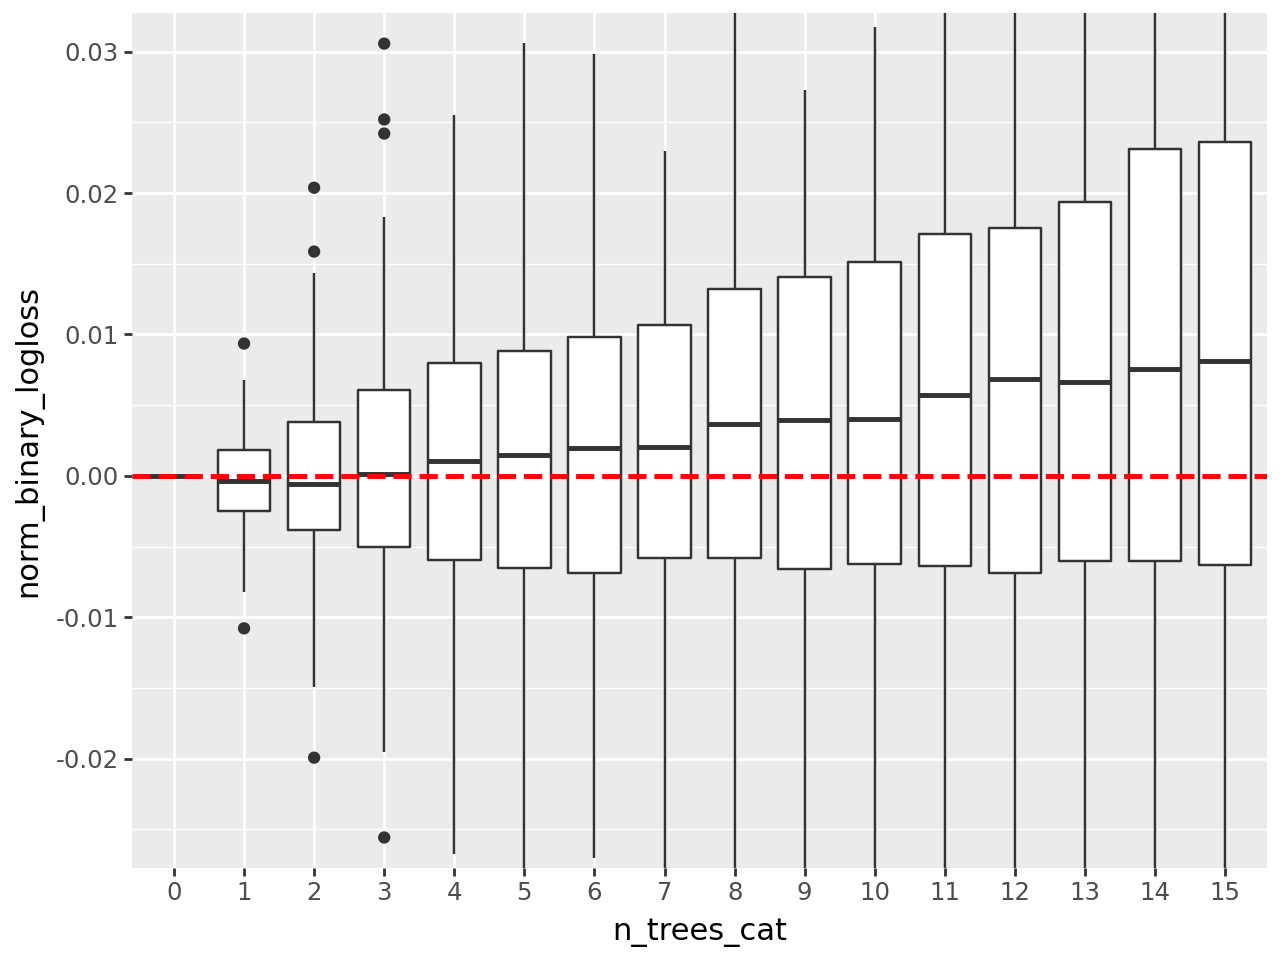

In [240]:
(
    ggplot(
        test_lc[test_lc["n_trees"] < 16], aes(x="n_trees_cat", y="norm_binary_logloss")
    )
    + geom_boxplot(outlier_alpha=None)
    + coord_cartesian(ylim=[-0.025, 0.03])
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
)

We check the feature importance, to see that there are no anormal values

In [241]:
feature_importance_summary = {}

for model_name, model in all_models.items():
    feature_importance = draw_feature_importance(model)

    feature_importance_df = pd.DataFrame(
        {
            "Feature": feature_importance["feature"],
            "Importance": feature_importance["imp"],
        }
    )

    feature_importance_summary[model_name] = feature_importance_df.set_index("Feature")[
        "Importance"
    ]

feature_importance_summary_df = pd.DataFrame(feature_importance_summary)
feature_importance_summary_df["Mean_Importance"] = feature_importance_summary_df.mean(
    axis=1
)
feature_importance_summary_df = feature_importance_summary_df.sort_values(
    by="Mean_Importance", ascending=False
)

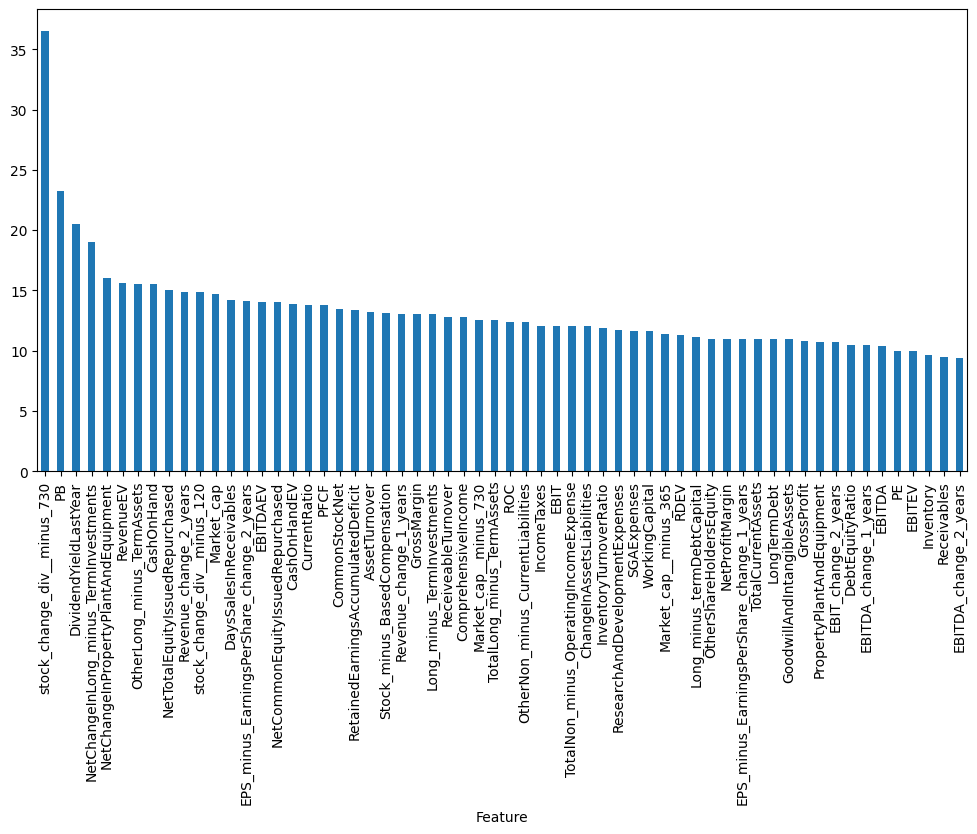

In [250]:
feature_importance_summary_df["Mean_Importance"].plot(kind="bar", figsize=(12, 6))
plt.show()

There isn't a values very high, being the most higher "sp500_change_730", but no represent something anormal

In [262]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")

In [264]:
test_results_final_tree = get_baseline(test_results_final_tree, all_predicted_tickers)

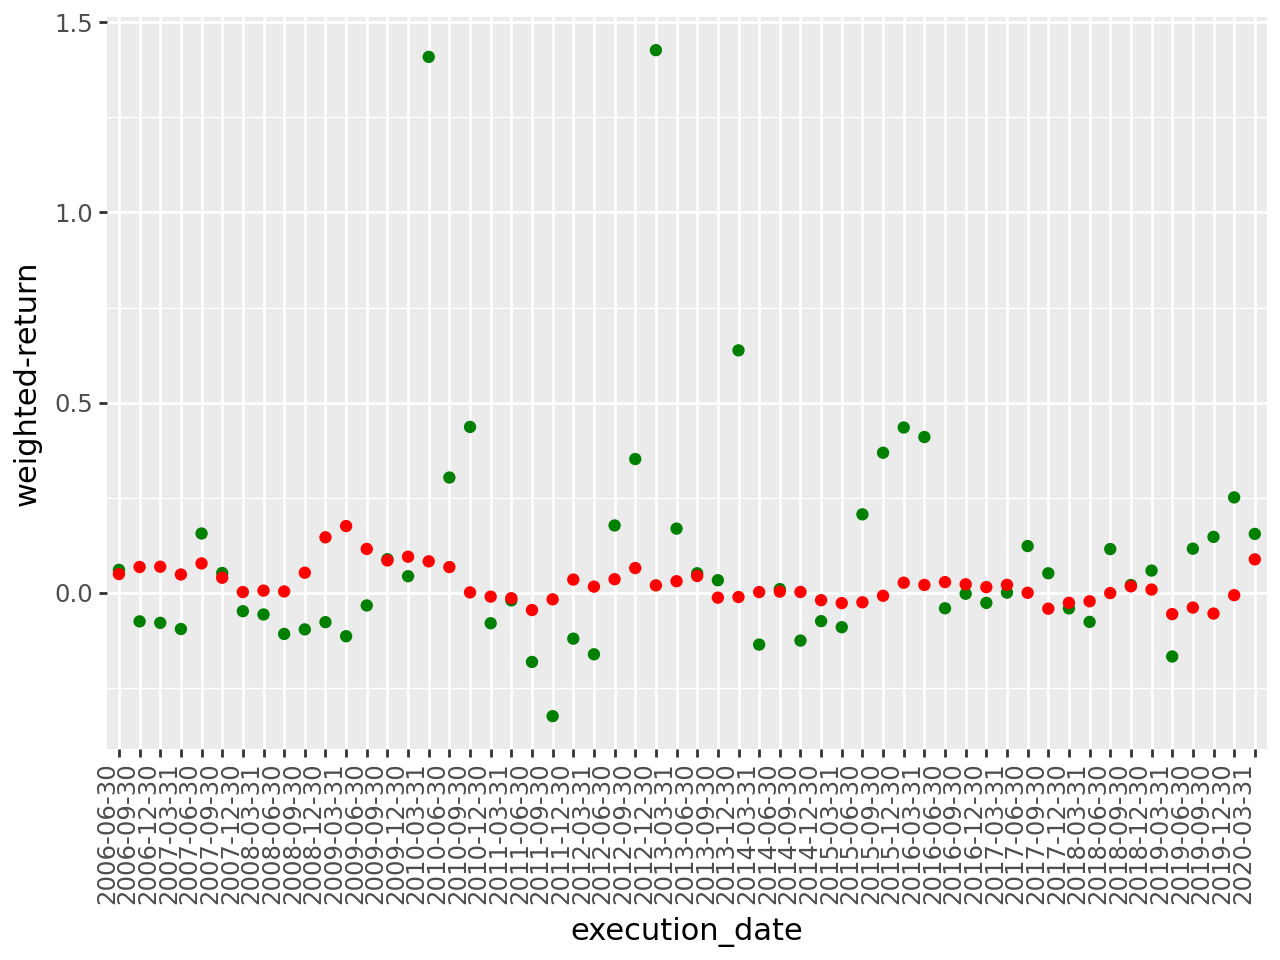

In [ ]:
plot = (
    ggplot()
    + geom_point(
        test_results_final_tree[test_results_final_tree["weighted-return"] < 2],
        aes(x="execution_date", y="weighted-return"),
        color="green",
    )
    + geom_point(
        test_results_final_tree[test_results_final_tree["diff_ch_sp500_baseline"] < 2],
        aes(x="execution_date", y="diff_ch_sp500_baseline"),
        color="red",
    )
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)
plot

The results show that the model performs worse than at the start, but this is normal given that it no longer to has data leakage and avoids overfitting. On the other hand, it is still riskier, taking risky measures, compared to the baseline, which is more conservative and carries less risk.

In [267]:
test_results_final_tree[
    test_results_final_tree["weighted-return"]
    < test_results_final_tree["diff_ch_sp500_baseline"]
].shape[0] / test_results_final_tree.shape[0]

0.5

After the changes, the model works half as often as the baseline.

In [268]:
print(
    f"model median: {test_results_final_tree['weighted-return'].median():.3f}  Baseline median: {test_results_final_tree['diff_ch_sp500_baseline'].median():.3f}"
)
print(
    f"model mean: {test_results_final_tree['weighted-return'].mean():.3f}  Baseline mean: {test_results_final_tree['diff_ch_sp500_baseline'].mean():.3f}"
)

model median: 0.015  Baseline median: 0.016
model mean: 0.096  Baseline mean: 0.022


as it was said, the model's predictions will be higher and riskier, showing a higher average gain than the baseline, but it is offset by the losses.

Our model looks better because sometimes the return is very high in some moments. But the median is negative (even if it is almost 0), so we need to invest for a long time to do better than the S&P 500.  

Another possible problem is the data, because the average and the median are very different.

#### **Changes Implemented**  
1. **Baseline Creation:**  
   - A baseline model was created to compare performance.  
   - Used **average surplus** (difference between current value and 5-year average).  
   - The model performed **better than the baseline**, but this could be due to **data leakage**.  

2. **Overfitting Check:**  
   - Used **binary log loss** to evaluate overfitting.  
   - Plotted its evolution as the number of trees increased.  
   - Initially, used **line plots**, later switched to **boxplots** for better visualization.  
   - **Observed overfitting** after a certain number of trees (log loss decreased in validation).  
   - **Limited the number of trees to 12** to prevent overfitting.  

3. **Feature Importance Analysis:**  
   - Detected **anomalous feature values** related to **The CYCC Case**.  
   - Identified and **removed features causing data leakage**.  

4. **Final Model Training:**  
   - Retrained models after removing data leakage and overfitting issues.  
   - **Performance decreased** but is now **free of biases**.  
   - Model now performs similarly to the **baseline**, but takes **riskier decisions**, achieving the same average return as a **more conservative benchmark**.